In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd

# Append utils as a module
module_path = os.path.abspath(os.path.join('utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from move_direction import move_abs_direction
from move_length import move_length
from data_preprocessing import *
from plot_helpers import plot_on_screen
from helpers import traject_to_coord, slice_gen

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_df = pd.read_csv('data/et_raw_data.csv')
print(raw_df.shape)
raw_df.head()

(1999941, 9)


,fix,x,y,blink,time,frame,user,task,frame_num
0,1,0.37455,0.09229,0,0.00000,2_news_0,2,news,0
1,1,0.37268,0.09873,0,0.03284,2_news_1,2,news,1
2,1,0.36792,0.09157,0,0.06604,2_news_2,2,news,2
3,1,0.36680,0.08825,0,0.09863,2_news_3,2,news,3
4,1,0.36246,0.07916,0,0.13147,2_news_4,2,news,4


Initial shape (1999941, 9)


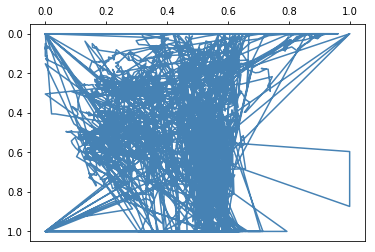

removed blinks and non-fixations (1419401, 9)


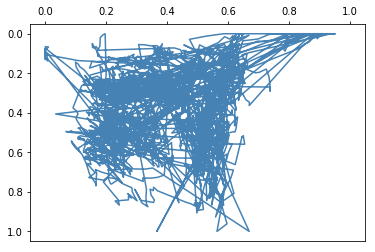

removed jittering (1281403, 9)


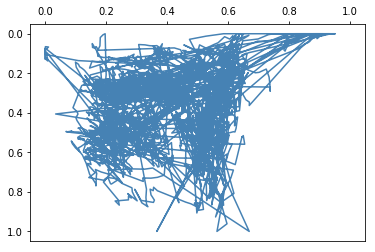

In [3]:
## Clean the data

df = raw_df.copy()
print("Initial shape", df.shape)

p = plot_on_screen(df.x.values[:5000], df.y.values[:5000])
plt.show()

df = df[df['fix'] == 1] # leave only fixations
df = df[df['blink'] != 1] # filter rows with blinks
df.x = df.x.clip(0, 1) # limit x and y values
df.y = df.y.clip(0, 1) # limit x and y values

print("removed blinks and non-fixations", df.shape)
p = plot_on_screen(df.x.values[:5000], df.y.values[:5000])
plt.show()

# Filter movements less than delta
df = remove_tiny_moves(df, delta=0.001)
print("removed jittering", df.shape)

p = plot_on_screen(df.x.values[:5000], df.y.values[:5000])
plt.show()

In [4]:
## Compute features

x = df.x.values
y = df.y.values

directions = move_abs_direction(x, y, invert_y=True, radians=True)
df['move_dir'] = np.insert(directions, 0, 0)#np.nan)
df['move_dir_norm'] = norm_values(df['move_dir'], 0, 2 * np.pi)

lenghts = move_length(x, y)
df['move_len'] = np.insert(lenghts, 0, 0)#np.nan)
df.loc[df['move_len'] > 1.44, 'move_len'] = 1.44
df['move_len_norm'] = norm_values(df['move_len'], 0, 1.44)

# move_time = (df.time - df.time.shift()).fillna(0)
# move_time[move_time < 0] = 0
# df['move_time'] = move_time
# norm time?

# one-hot encoding for labels
df['task_cat'] = df.task.astype('category').cat.codes

print(df.shape)
df.head()

(1281403, 14)


,fix,x,y,blink,time,frame,user,task,frame_num,move_dir,move_dir_norm,move_len,move_len_norm,task_cat
0,1,0.37455,0.09229,0,0.00000,2_news_0,2,news,0,0.000000,0.000000,0.000000,0.000000,1
1,1,0.37268,0.09873,0,0.03284,2_news_1,2,news,1,3.424194,0.544977,0.006706,0.004657,1
2,1,0.36792,0.09157,0,0.06604,2_news_2,2,news,2,5.696473,0.906622,0.008598,0.005971,1
3,1,0.36680,0.08825,0,0.09863,2_news_3,2,news,3,5.957824,0.948217,0.003504,0.002433,1
4,1,0.36246,0.07916,0,0.13147,2_news_4,2,news,4,5.837742,0.929105,0.010073,0.006995,1


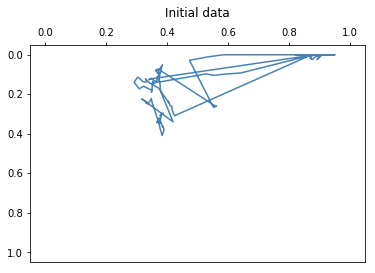

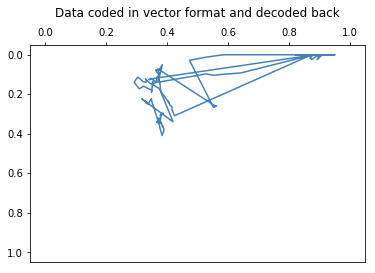

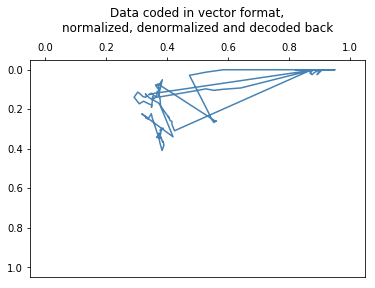

In [5]:
# Check if we can restore data from normalization

ss, se = 1, 150 # range to check

# initial data
test_xy = df[['x', 'y']][ss-1:se].values
x_init = test_xy[0, 0] # first point location
y_init = test_xy[0, 1]

p = plot_on_screen(test_xy[:, 0], test_xy[:, 1], title="Initial data")
plt.show()

# data coded in vector direction and length
test_vec = df[['move_dir', 'move_len']][ss:se].values
xy = traject_to_coord(test_vec[:, 0], test_vec[:, 1], x_init, y_init)
p = plot_on_screen(xy[:, 0], xy[:, 1], title="Data coded in vector format and decoded back")
plt.show()

# data coded in vector direction and length, normalized, denormalized and decoded back
test_norm = df[['move_dir_norm', 'move_len_norm']][ss:se].values
md = denorm(test_norm[:, 0], x_max=2*np.pi)
ml = denorm(test_norm[:, 1], x_max=1.44)
xy = traject_to_coord(md, ml, x_init, y_init)
p = plot_on_screen(xy[:, 0], xy[:, 1], 
                   title="Data coded in vector format,\nnormalized, denormalized and decoded back")
plt.show()

In [6]:
# Number of observations per class
df.task_cat.value_counts()

5    337119
6    301754
4    243349
1    218792
0     97425
3     70542
2     12422
Name: task_cat, dtype: int64

In [10]:
timesteps = 30
features = ['move_dir_norm', 'move_len_norm']
one_hot = False

df_ = df.copy()
df_ = df_[(df_.task_cat != 2)] # omit the task with very few observations

x_d = df_[features].values
y_d = df_['task_cat'].values
if one_hot:
    y_d = pd.get_dummies(y_d)

data_range = np.arange(np.floor(len(x_d)/timesteps))

# drop those where label is ambiguous
y_labels = slice_gen(y_d, timesteps)
y_not_mixed = [True if len(set(next(y_labels))) == 1 else False for i in data_range]

# split into seqs of length N (non-overlapped)
x_gener = slice_gen(x_d, timesteps)
y_gener = slice_gen(y_d, timesteps)

# limit generator to one loop over the data
x_gen = [next(x_gener) for i in data_range]
y_gen = [next(y_gener)[0] for i in data_range]

x_data = np.array(x_gen)
y_data = np.array(y_gen)

x_data = x_data[y_not_mixed]
y_data = y_data[y_not_mixed]

print('x_data shape', x_data.shape)
print('y_data shape', y_data.shape)

x_data shape (42160, 30, 2)
y_data shape (42160,)


In [11]:
# Codes for categories
# check in initial data and in results by the number of observations

task_counts = np.unique(df_.task.values, return_counts=True)
task_counts = list(zip(task_counts[0], task_counts[1]))

yd_counts = np.unique(y_d, axis=0, return_counts=True)
yd_counts = list(zip(yd_counts[0], yd_counts[1]))

names_classes = {}
for n, c in task_counts:
    code = [x[0] for x in yd_counts if x[1] == c]
    if len(code) != 0:
        assert("Multiple or no matches for: {}".format(c))
    names_classes[n] = code[0].tolist()
names_classes

{'maps': 0, 'news': 1, 'search': 3, 'vk': 4, 'wiki': 5, 'youtube': 6}

In [12]:
# Save the data
np.save('data/x_data.npy', x_data)
np.save('data/y_data.npy', y_data)
print('Done!')

Done!
